In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from matplotlib import patches
from PIL import Image, ImageDraw

from pycocotools.coco import COCO

In [2]:
def binary2gray(x):
    return min(x*255, 255)

vbinary2gray = np.vectorize(binary2gray)

def create_mask_image(coco, image_id):
    img_infos = coco.imgs[image_id]
    cat_ids = coco.getCatIds()
    anns_ids = coco.getAnnIds(imgIds=img_infos['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(anns_ids)
    # coco.showAnns(anns)
    # mask = coco.annToMask(anns[0])
    # mask = np.zeros_like(coco.annToMask(anns[0]))
    mask = np.zeros((img_infos["height"], img_infos["width"]))
    for i in range(len(anns)):
        if anns[i]["segmentation"] != []:
            mask += coco.annToMask(anns[i])
        else:
            x, y, w, h = anns[i]["bbox"]
            x, y, w, h = round(x), round(y), round(w), round(h)
            mask[y : y + h, x : x + w] = 1

    mask = vbinary2gray(mask)

    return mask

# Visualizing prediction mask

In [3]:
def rle_to_binary_mask(rle, img_shape):
    value = 0
    mask_array = []
    for count in rle:
        mask_array.extend([int(value)] * count)
        value = (value + 1) % 2

    assert len(mask_array) == img_shape[0] * img_shape[1]
    b_mask = np.array(mask_array, dtype=np.uint8).reshape(img_shape)

    return b_mask

In [25]:
def binary_mask(segmentation, width=4096, height=1024):
    mask = Image.new("L", (width, height), (0))
    shape = []
    for points in segmentation:
        shape.append(tuple([points[0]*width,points[1]*height]))
    mask_draw = ImageDraw.Draw(mask)
    mask_draw.polygon(shape, fill="#FFFFFF")
    
    return np.array(mask, dtype=np.uint8)

In [26]:
def apply_mask(image, mask, color, alpha=0.5):
    a_mask = np.stack([mask] * 3, axis=2).astype(np.int8)
    for c in range(3):
        image[:, :, c] = np.where(
            mask == 1, image[:, :, c] * (1 - alpha) + alpha * color[c] * 255, image[:, :, c]
        )
    return image

In [27]:
import colorsys
import random


def random_colors(N, bright=False):
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [28]:
def show_detection_results(img=None, annotations=None, score_th=0, show_mask=False, x_off=0, y_off=0, human=False):
    """
    img: image numpy array
    annotations: annotations array for image where each annotation is in COCO format
    """
    if human:
        categories = {10: 'border', 11: 'sticker', 1: 'DEFECT OF WEFT', 2: 'IRREGULAR YARN', 3: 'DEFECT OF PRINTING', 4: 'OTHERS', 5: 'STAINS', 6: 'CREASES', 7: 'HOLES', 8: 'DEFECT OF DYEING', 9: 'ABRASIONS', 12: 'KNOTS'}
    else:
        categories = {1: "defect", 10: "border", 11: "sticker"}
    num_annotations = len(annotations)
    colors = random_colors(num_annotations)

    # fig, (ax1,ax2) = plt.subplots(1,2, figsize=(img.shape[1] // 50, img.shape[0] // 50))
    # fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 20))
    # ax1.imshow(img.astype(int))
    fig, ax2 = plt.subplots(1,1, figsize=(50, 20))
    
    def_count = 0
    for i, a in enumerate(annotations):
        if show_mask:
            # segm = a["segmentation"]

            # img_shape = tuple(segm["size"])
            # rle = segm["counts"]
            # binary_image_mask = rle_to_binary_mask(rle, img_shape)
            segm = a["segmentation"]
            binary_image_mask = binary_mask(segm)

        bbox = a["bbox"]
        category_id = a["category_id"]
        category_name = categories[category_id]
        if human:
            score = 1.0
        else:
            score = a["score"]
        if float(score) >= score_th:
            if category_name == "defect":
                def_count += 1

            # select color from random colors
            color = colors[i]

            # Show bounding box
            bbox_x, bbox_y, bbox_w, bbox_h = bbox

            box_patch = patches.Rectangle(
                (bbox_x + x_off, bbox_y + y_off),
                bbox_w,
                bbox_h,
                linewidth=3,
                alpha=0.7,
                linestyle="dashed",
                edgecolor=color,
                facecolor="none",
            )
            ax2.add_patch(box_patch)
            # label = f"{category_name}:{category_id} - score:{float(score):.2f}"
            label = f"{category_name} - score:{float(score):.2f}"
            ax2.text(bbox_x, bbox_y - 20, label, color="b", size=14, backgroundcolor="none")

            # Show mask
            if show_mask:
                img = apply_mask(img, binary_image_mask.astype(np.bool_), color)
        
    ax2.imshow(img.astype(int))
    if def_count > 0:
        plt.show()
    return img.astype(np.uint8)

## Main

In [38]:
path_pred = "./results/output.json"
with open(path_pred, "r") as j:
    data_pred = json.load(j)

In [39]:
df_pred = pd.DataFrame(data_pred)
images_vis = np.unique(["_".join(x.split("_")[:3]) for x in df_pred["image_id"].values])[:10]

F0_R115652_C0.jpg


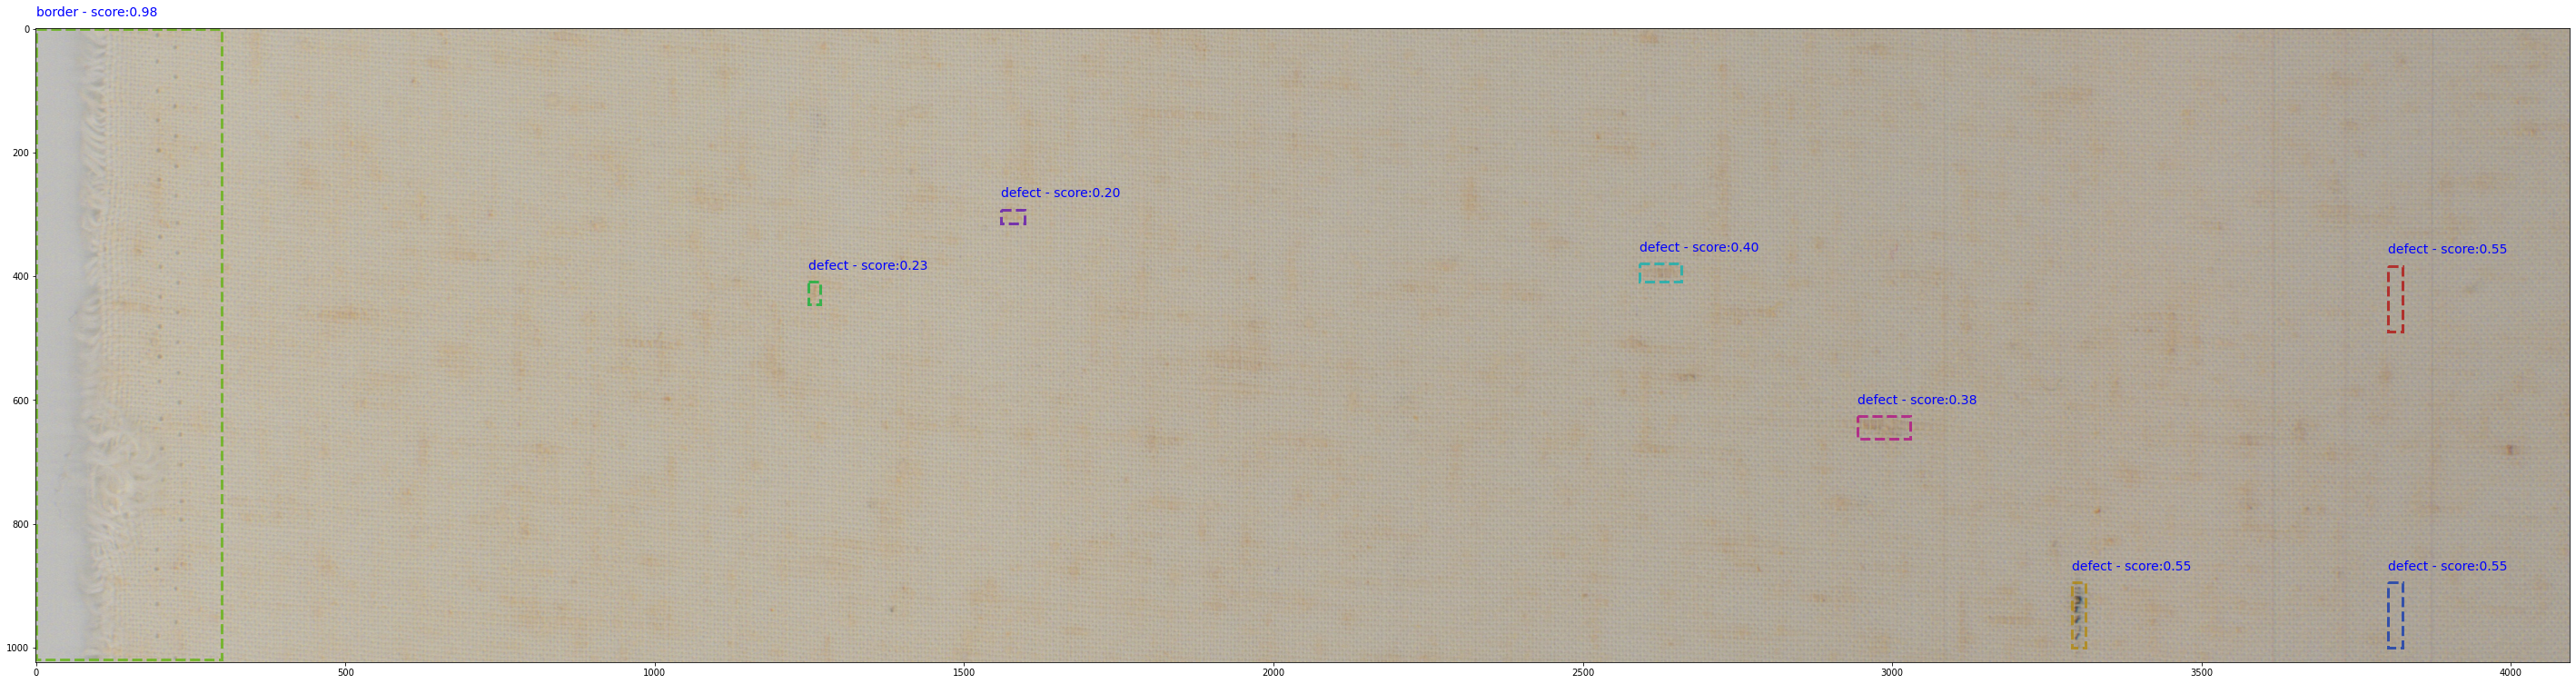

In [41]:
img_prefix = images_vis[0]
flag = True
df_aux = df_pred[df_pred["image_id"].str.startswith(img_prefix)].sort_values(by="image_id")
for i in range(len(df_aux)):
    S3 = "s3://aqc-technology-qualitex-images"
    img_name = df_aux["image_id"].values[i][:-4] + ".jpg"
    print(img_name)
    img = cv.imread(f"./eval_lectra/{img_name}")
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    show_detection_results(img, df_aux["annotations"].values[i],score_th=0, show_mask=False)
    plt.show()